In [17]:
from pathlib import Path
import numpy as np
import hicstraw
import seaborn as sns
import matplotlib.pyplot as plt

In [18]:
m = 1
um = 1e-6 * m 
nm = 1e-9 * m 
s = 1
ms = 1e-3 * s
us = 1e-6 * s
ns = 1e-9 * s
M = 6.02 * 10 ** 23 / m ** 3
uM = 1e-6 * M

# Setup

In [19]:
hic_path = Path("/Users/ishangaur/ep-analysis/GSM4873116_WT-HUDEP2-captureHiC_allValidPairs.hic")
hic = hicstraw.HiCFile(str(hic_path))
print("Number of chromosome objects:", len(hic.getChromosomes()))
print("Genome ID:", hic.getGenomeID())
res = hic.getResolutions()
print("Available resolutions:", np.asarray(res) / 1000, "kb")

Number of chromosome objects: 26
Genome ID: /secondary/projects/zhang/tools/Hic-Pro/HiC-Pro_2.8.0/annotation/chrom_hg19.sizes
Available resolutions: [2500. 1000.  500.  250.  100.   50.   25.   10.    5.] kb


So want to request 5299 and 5304 kb on the rows to get the HS2 enhancer and do the full range (5270 to 5303) plus mb a two similar length pieces on either side

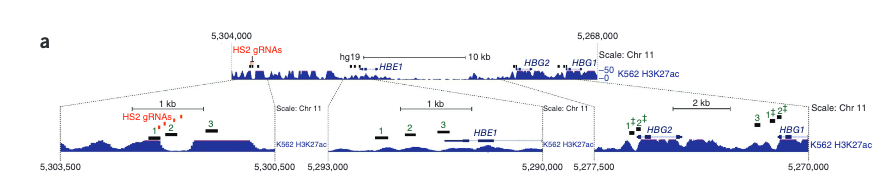
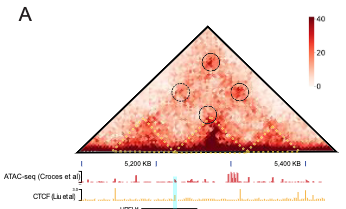

In [20]:
HS2_loc = (5300000, 5303000)
HBE1_loc = (5290000, 5293000)
HBG1_loc = (5270000, 5273000)
HBG2_loc = (5274000, 5276000)

HBG_TAG_loc = (5225000, 5349000)

In [21]:
mzd = hic.getMatrixZoomData("11", "11", "observed", "KR", "BP", hic.getResolutions()[-1])
probs = mzd.getRecordsAsMatrix(HS2_loc[0], HS2_loc[1], HBG_TAG_loc[0], HBG_TAG_loc[1])
probs = probs / probs.sum()
print(probs.shape)
print(probs)
probs = probs[0]

(1, 25)
[[0.02144649 0.01250274 0.01176873 0.02265363 0.03043035 0.02658108
  0.01635145 0.01783358 0.01602282 0.0116351  0.02028131 0.02650136
  0.02757081 0.0383168  0.19656818 0.09022713 0.20995567 0.07028622
  0.03774652 0.03543269 0.02248637 0.01550706 0.00851119 0.00904221
  0.00434052]]


What's up with the little U in the max probability at indices (0-indexed) 14 to 16?

"0.20420567 0.09373283 0.21811332"

These are also the max!

In [22]:
np.argmax(probs)

16

In [23]:
def geneIndexIn(geneLoc, TAGLoc, res):
    return int((geneLoc[0] - TAGLoc[0]) / res), int((geneLoc[1] - TAGLoc[0]) / res)

Where do each of our points of interest fall in this chart?

In [24]:
print(geneIndexIn(HS2_loc, HBG_TAG_loc, res[-1]))
print(geneIndexIn(HBE1_loc, HBG_TAG_loc, res[-1]))
print(geneIndexIn(HBG1_loc, HBG_TAG_loc, res[-1]))
print(geneIndexIn(HBG2_loc, HBG_TAG_loc, res[-1]))

(15, 15)
(13, 13)
(9, 9)
(9, 10)


<Axes: >

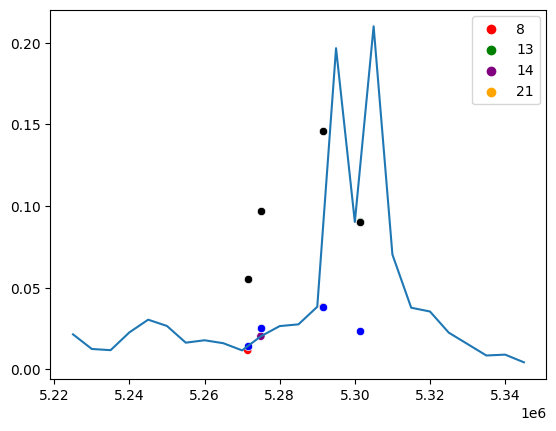

In [25]:
from statistics import mean
HS2, HBE1, HBG1, HBG2 = 15, 13, 9, 10
HS2_ac, HBE1_ac, HBG1_ac, HBG2_ac = 13, 21, 8, 14 # note the HBG1 and 2 are taking into account the duplicate amplicons
ac_levels = np.asarray([HS2_ac, HBE1_ac, HBG1_ac, HBG2_ac])
locs = [HS2_loc, HBE1_loc, HBG1_loc, HBG2_loc]
indices = [HS2, HBE1, HBG1, HBG2]
pos = {HS2: 0, HBE1: 1, HBG1: 2, HBG2: 3}
colors = ['red', 'green', 'purple', 'orange']

sns.lineplot(x=np.arange(HBG_TAG_loc[0], HBG_TAG_loc[1], res[-1]), y=probs)
sns.scatterplot(x=[mean(loc) for loc in locs], y=[probs[i] for i in indices], hue=ac_levels, palette=colors)
sns.scatterplot(x=[mean(loc) for loc in locs], y=ac_levels / ac_levels[pos[HS2]] * probs[HS2], color="black")
sns.scatterplot(x=[mean(loc) for loc in locs], y=ac_levels / ac_levels[pos[HBE1]] * probs[HBE1], color="blue")

# Diffusion Simulation

For this simulation, we will consider a 1 cubic micron box with 10 nm voxels (giving 10^6 voxels)
We will simulate diffusion with Fick's law: $\delta_t C = -D * \delta_x C$, where $C$ is the concentration and $D$ is the diffusion coefficient.

A priori, we know we have a constant HDAC concentration. If this is much higher than the transcription factors, we would expect the diffusion radius to be proportional to the expected distance of the random walk for the mean binding time to HDAC.

The expected distance is 

Text(0.5, 1.0, 'Distribution of displacements--ie when a tf is deacetylated')

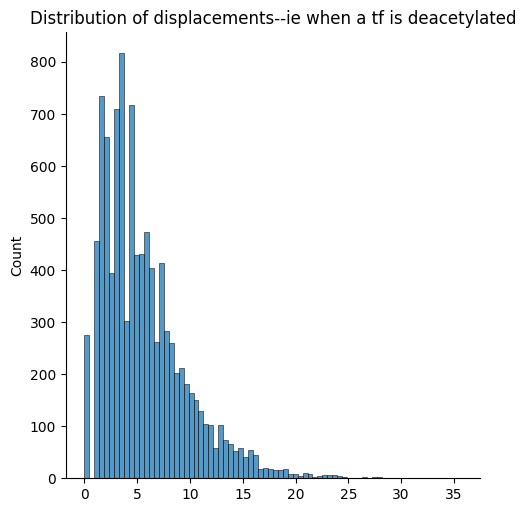

In [26]:
C_HDAC = 0.1 # prob of finding an HDAC in a given voxel
P_acetylation_if_HDAC = 0.2 # prob of acetylation
P_acetylation = C_HDAC * P_acetylation_if_HDAC

displacements = []
for i in range(10000):
    tf = np.array([0, 0, 0])
    acetylated = False
    while not acetylated:
        acetylated = np.random.choice([True, False], p=[P_acetylation, 1 - P_acetylation])
        if acetylated:
            displacements.append(np.linalg.norm(tf))
        else:
            index = np.random.choice([0, 1, 2])
            tf[index] += np.random.choice([-1, 1])

sns.displot(displacements)
plt.title("Distribution of displacements--ie when a tf is deacetylated")

In [27]:
dt = 1 * s
side_n = 11
voxel_len = 5 * nm
voxel_size = voxel_len ** 3
world = np.zeros((side_n, side_n, side_n))
# D = 3 * um ** 2 / s
D = 10 * um ** 2 / s

def apply_Ficks(i, j, k, world, new_world, dt):
    d_x = (world[i + 1, j, k] if i + 1 < side_n else 0) - (world[i - 1, j, k] if i - 1 >= 0 else 0)
    d_y = (world[i, j + 1, k] if j + 1 < side_n else 0) - (world[i, j - 1, k] if j - 1 >= 0 else 0)
    d_z = (world[i, j, k + 1] if k + 1 < side_n else 0) - (world[i, j, k - 1] if k - 1 >= 0 else 0)
    J = -1 * D * np.array([d_x, d_y, d_z]) / (2 * voxel_len)
    dC = J * dt 

    new_world[i, j, k] -= dC.sum()
    if i + 1 < side_n:
        new_world[i + 1, j, k] += dC[0] / 2
    if i - 1 >= 0:
        new_world[i - 1, j, k] -= dC[0] / 2
    if j + 1 < side_n:
        new_world[i, j + 1, k] += dC[1] / 2
    if j - 1 >= 0:
        new_world[i, j - 1, k] -= dC[1] / 2
    if k + 1 < side_n:
        new_world[i, j, k + 1] += dC[2] / 2
    if k - 1 >= 0:
        new_world[i, j, k - 1] -= dC[2] / 2

    return new_world

def coord_to_index(x, y, z):
    indices = [c + side_n // 2 for c in [x, y, z]]
    return indices[0], indices[1], indices[2]

In [28]:
nucleus_radius = 10 / 2 * um
nuclear_volume = 4 / 3 * np.pi * nucleus_radius ** 3
nucleolar_radius = 1 / 2 * um
nucleolar_volume = 4 / 3 * np.pi * nucleolar_radius ** 3

In [29]:
volume = nucleolar_volume
tf_num_nucleus = 1500
C_tf = tf_num_nucleus / nuclear_volume # prob of finding a tf in a given voxel

promoter_frequency = 1 / (30 * s) # switching frequency from Zuin et al. 2022

# nuclear_acetyl_coa = 3 * uM # in cancer cells, Sivanand 2018

# p300 model gives a uniform chance of acetylation in a given volume
P_p300_ac = 1 / (10 * ns) # prob of acetylation: ac_tf / ms * tf
p300_range = 3 * nm # range of p300: guesstimate from cross-linker spans as an upper bound
p300_vol = p300_range ** 3 * 4 / 3 * np.pi

tf_ac_production = C_tf * P_p300_ac * p300_vol # ac_tf / s
tf_ac_production = 0

print(p300_vol * (m / nm) ** 3, "nm^3", tf_ac_production, "ac_tf/s")

113.09733552923254 nm^3 0 ac_tf/s


In [30]:
num_HDAC = 5000
C_HDAC = num_HDAC / volume
P_deacetylation_if_HDAC = 0.5 / ms # prob of deacetylation: deac_tf / ms * ac_tf
P_deacetylation = C_HDAC * P_deacetylation_if_HDAC * voxel_size
P_deacetylation = 0
print(P_deacetylation, "deacetylation/voxel*s")

0 deacetylation/voxel*s


In [31]:
def update_world(world):
    x, y, z = coord_to_index(0, 0, 0)
    new_world = np.copy(world)
    new_world[x, y, z] += tf_ac_production * dt
    for i in range(side_n):
        for j in range(side_n):
            for k in range(side_n):
                new_world = apply_Ficks(i, j, k, world, new_world, dt)
    new_world -= P_deacetylation * world * dt
    return new_world

<Axes: >

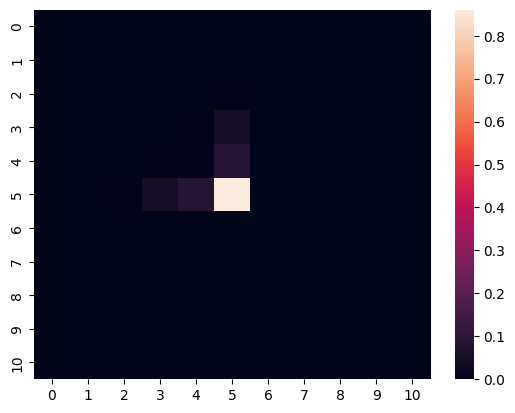

In [32]:
x, y, z = coord_to_index(0, 0, 0)
world[:, : , :] = 0
world[x, y, z] = 1
T = 100 * s
for t in range(int(T / dt)):
    world = update_world(world)

sns.heatmap(world[:, :, side_n // 2])